In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Download and extract the dataset
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='fruits.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fruits.zip')
f.keys()
!unzip fruits.zip

Archive:  fruits.zip
replace fruits/test/apple/Image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fruits/test/apple/Image_1.jpg  
  inflating: fruits/test/apple/Image_10.jpg  
  inflating: fruits/test/apple/Image_2.jpg  
  inflating: fruits/test/apple/Image_3.jpg  
  inflating: fruits/test/apple/Image_4.jpg  
  inflating: fruits/test/apple/Image_5.jpg  
  inflating: fruits/test/apple/Image_6.JPG  
  inflating: fruits/test/apple/Image_7.jpg  
  inflating: fruits/test/apple/Image_8.jpg  
  inflating: fruits/test/apple/Image_9.jpg  
  inflating: fruits/test/banana/Image_1.jpg  
  inflating: fruits/test/banana/Image_10.jpg  
  inflating: fruits/test/banana/Image_2.jpg  
  inflating: fruits/test/banana/Image_3.jpg  
  inflating: fruits/test/banana/Image_4.jpg  
  inflating: fruits/test/banana/Image_5.jpg  
  inflating: fruits/test/banana/Image_6.jpg  
  inflating: fruits/test/banana/Image_8.jpg  
  inflating: fruits/test/banana/Image_9.jpg  
  inflating: fruits/test/kiwi/Imag

In [6]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NO_CLASSES = 5


In [7]:
# Create data generators for preprocessing

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [8]:
# Load the data
train_dataset = train_datagen.flow_from_directory(
    '/content/fruits/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

validation_dataset = validation_datagen.flow_from_directory(
    '/content/fruits/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    '/content/fruits/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 384 images belonging to 5 classes.
Found 48 images belonging to 5 classes.
Found 49 images belonging to 5 classes.


In [9]:
class_names = train_dataset.class_indices.keys()
print(class_names)

dict_keys(['apple', 'banana', 'kiwi', 'orange', 'watermelon'])


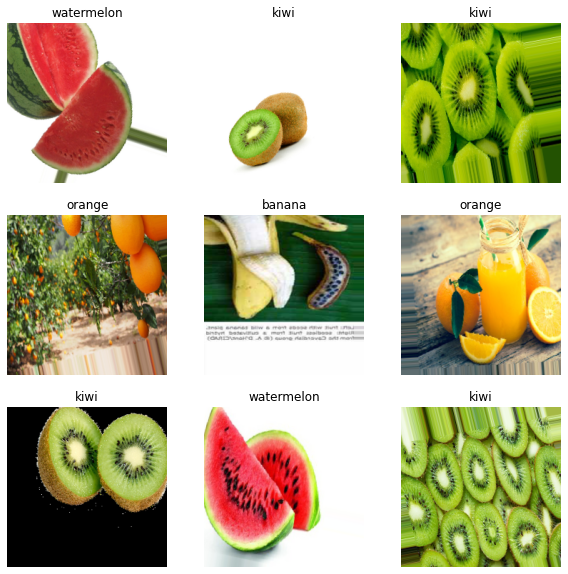

In [10]:
# Plot some images from the training dataset
import matplotlib.pyplot as plt

batch = next(train_dataset)
images = batch[0]
labels = batch[1]
class_names = list(train_dataset.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.show()


In [11]:
# Define the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.RandomContrast(0.2)(inputs)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NO_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0     

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
)

Epoch 1/25


 3/12 [======>.......................] - ETA: 48s - loss: 3.7292 - accuracy: 0.2188

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 [==============================] - 64s 5s/step - loss: 2.5951 - accuracy: 0.2318 - val_loss: 1.5713 - val_accuracy: 0.2917
Epoch 2/25
12/12 [==============================] - 72s 6s/step - loss: 1.5885 - accuracy: 0.2578 - val_loss: 1.5010 - val_accuracy: 0.2500
Epoch 3/25
12/12 [==============================] - 61s 5s/step - loss: 1.5298 - accuracy: 0.2865 - val_loss: 1.3116 - val_accuracy: 0.4792
Epoch 4/25
12/12 [==============================] - 59s 5s/step - loss: 1.3404 - accuracy: 0.3828 - val_loss: 1.0115 - val_accuracy: 0.5625
Epoch 5/25
12/12 [==============================] - 60s 5s/step - loss: 1.1438 - accuracy: 0.5260 - val_loss: 0.9454 - val_accuracy: 0.5625
Epoch 6/25
12/12 [==============================] - 60s 5s/step - loss: 1.0475 - accuracy: 0.5859 - val_loss: 0.9069 - val_accuracy: 0.5833
Epoch 7/25
12/12 [==============================] - 60s 5s/step - loss: 0.9771 - accuracy: 0.6510 - val_loss: 0.8757 - val_accuracy: 0.6250
Epoch 8/25
12/12 [=============

In [13]:
#Evaluating the trained mmodel by test_dataset
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 [==============================] - 11s 4s/step - loss: 0.5446 - accuracy: 0.7551
Test Loss: 0.5445980429649353
Test Accuracy: 0.7551020383834839


Saving download.jpeg to download.jpeg


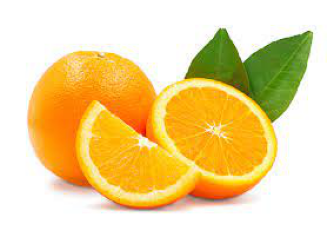

1/1 [==============================] - 0s 43ms/step
The predicted class is: orange


In [23]:
#Testing by userinput image
import IPython.display as display
from PIL import Image
import io
from google.colab import files
from tensorflow import keras


# Prompt the user to upload an image file
uploaded_file = files.upload()

# Load the image using Pillow
img = Image.open(io.BytesIO(uploaded_file[next(iter(uploaded_file))]))

# Display the uploaded image
plt.imshow(img)
plt.axis('off')
plt.show()

# Save the image to the content folder
img.save('uploaded_image.jpg')

# Load the image from the content folder
img = keras.preprocessing.image.load_img(
    'uploaded_image.jpg', target_size=(224, 224)
)

# Convert the image to a numpy array
img_array = keras.preprocessing.image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = keras.applications.resnet50.preprocess_input(img_array)

# Make a prediction using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print("The predicted class is:", predicted_class_name)
